In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# The Max-Cut Problem

Given an undirected graph $G=(V,E)$ with $n=∣V∣$ vertices (and $m=∣E∣$ edges), the Max-Cut problem asks for a partition of the vertex set into two disjoint subsets $S$ and $V\setminus S$ that maximises the number of edges whose endpoints lie on opposite sides of the partition. Picture placing the vertices in $S$ on one side and those in $V\setminus S$ on the other; the “cut” consists of every edge running between the two sides, and the optimal solution has the largest number of such edges.

We can represent a solution (or "cut") to the Max-Cut problem using a bitstring, where $0$ and $1$ denote different sets. Below, we define functions to convert an integer to its bitstring.


In [3]:
def int2bits(k, n):
    return format(k, f"0{n}b")

We'll be using `NetworkX` to generate graphs in this workshop.

You can generate a random graph with $n$ using the `gnp_random_graph` function.  

In [4]:
n = 7 # number of nodes
edge_prob = 0.5 # probability of edge creation

G = nx.gnp_random_graph(n, edge_prob, seed=42) # create a random graph using networkx


We can retrieve the number of nodes  in `G` using its `get_number_of_nodes` method. The  `cut_value` function below uses the `edges` method to iterate over the edges of `G`,  where tuple `(u, v)`  denotes a connection between vertices `u` and `v`.

`NetworkX` also provides basic graph visualisation, which we use  to define `plot_graph` to visualise Max-cut solutions.

In [5]:
def cut_value(bitstring, G):
    """
    Compute the value of a cut on graph G.
    """
    z = [int(b) for b in bitstring]
    return sum(z[u] != z[v] for u, v in G.edges())/2


def plot_graph(G, cut = None):
    """
    Visualise a cut on graph G, or plot the graph  if the cut is `None`.
    """
    pos = nx.spring_layout(G, seed=17)
    plt.figure(figsize=(5, 5))

    if cut != None:
        bits = [int(b) for b in cut]
        part0 = [v for v in G.nodes if bits[v] == 0]
        part1 = [v for v in G.nodes if bits[v] == 1]
        cut_edges = [(u, v) for u, v in G.edges if bits[u] != bits[v]]
        same_edges = [(u, v) for u, v in G.edges if bits[u] == bits[v]]
        nx.draw_networkx_nodes(G, pos, nodelist=part0, node_color='tab:blue', label='0')
        nx.draw_networkx_nodes(G, pos, nodelist=part1, node_color='tab:orange', label='1')
        nx.draw_networkx_edges(G, pos, edgelist=same_edges, edge_color='gray')
        nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='red', style='dashed', width=2)
    else:
        nx.draw_networkx_nodes(G, pos) 
        nx.draw_networkx_edges(G, pos, width=2)
    
    nx.draw_networkx_labels(G, pos)
    if cut != None:
        plt.title(f"Max-Cut Solution: {cut}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Can you find the optimal cut to `G`?

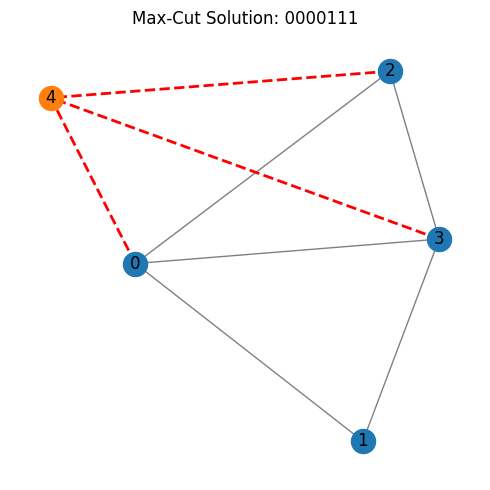

Cut value: 1.5


In [6]:
n = 5
edge_prob = 0.7
G = nx.gnp_random_graph(n, edge_prob, seed = 42)
cut = '0000111'
plot_graph(G, cut = cut)
print(f'Cut value: {cut_value(cut, G)}')

Max-Cut is an interesting problem in the context of quantum computing. For one,  it's a simple problem to state that is computationally tough. It belongs to the NP-hard complexity class, meaning that while it is easy to compute the value of a given cut, it is widely held that an algorithm that can find an optimum cut in polynomial time does not exist. It's also the case that many optimisation tasks can be framed as a Max-cut problem, such as electrical circuit layouts, spin models and even portfolio rebalancing. 

To understand how the Max-cut problem's hardness scales with the number of nodes $n$, we can compute how many solutions we need to query on average before encountering the optimal cut value.

Even after finding a globally optimal cut, verifying this generally still requires evaluating the entire solution space, which is of size $2^n$.

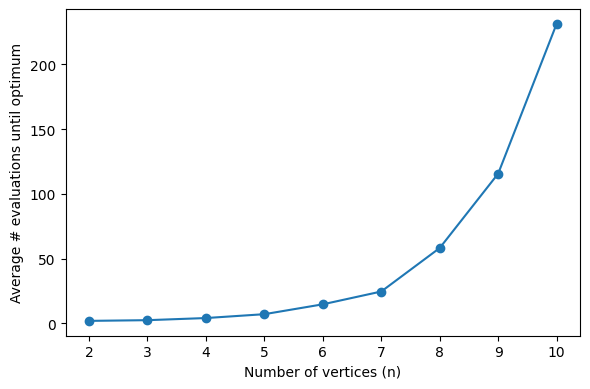

In [7]:
def first_optimum(n, G):
    best_val, evals_to_best, best_bs = -1, 0, None
    for i in range(2**n):
        bs = int2bits(i, n)
        val = cut_value(bs, G)
        if val > best_val:
            best_val, evals_to_best, best_bs = val, i + 1, bs
    return evals_to_best, best_val, best_bs

n_min, n_max = 2, 10
samples_per_n = 50
edge_prob = 0.5

avg_evals = []
ns = list(range(n_min, n_max + 1))

for n in ns:
    evals_list = []
    for _ in range(samples_per_n):
        G = nx.gnp_random_graph(n, edge_prob)
        if G.number_of_edges() == 0:
            continue
        evals, _, _ = first_optimum(n, G)
        evals_list.append(evals)
    if evals_list:
        avg_evals.append(sum(evals_list) / len(evals_list))
    else:
        avg_evals.append(float('nan'))

plt.figure(figsize=(6,4))
plt.plot(ns, avg_evals, marker='o')
plt.xlabel("Number of vertices (n)")
plt.ylabel("Average # evaluations until optimum")
plt.tight_layout()
plt.show()

# The Quantum Approximate Optimisation Algorithm


# Quantum Approximate Optimisation Algorithm (QAOA)

The Quantum Approximate Optimisation Algorithm (QAOA) is a hybrid quantum–classical algorithm designed to solve combinatorial optimisation problems on near-term quantum devices. It encodes the problem into a cost Hamiltonian and evolves the quantum state through alternating applications of *cost* and *mixing* unitaries. A classical optimiser iteratively adjusts the parameters to minimise the expectation value of the cost Hamiltonian, with corresponds to a higher probability of measuring an optimal or near-optimal solution. 


## Algorithm Overview

### 1. Initial State

The algorithm begins in a uniform superposition,   

$$
\ket{\psi_0} = \frac{1}{\sqrt{2^n}}  \sum_{x\in\{0,1\}^n}\ket{x},
$$

where $n$ is the number of qubits.


### 2. Cost Unitary

The cost-unitary is defined as,

$$
U_C(\gamma) = \exp\bigl(-i\gamma\,C(\mathbf{Z})\bigr)
$$

where $\gamma$ is a tuneable classical parameter and $C(\mathbf{Z})$ encodes the cost associated with each solution in the solution space.

### 3. Mixing Unitary

The mixing unitary is defined as,

$$
U_M(\beta) = \exp\!\Bigl(-i\beta\sum_i X_i\Bigr)
$$

where $\beta$ is a classically tunable parameter and $X_i$ denotes is a NOT gate (or Puali-X gate) on the $i$-th qubit.

### 4. Hybrid Loop

Choose a depth $p$, then for layers $k=1,\dots,p$:

1. Prepare  
   $$
   \ket{\psi(\boldsymbol\gamma,\boldsymbol\beta)}
   = U_M(\beta_k)\,U_C(\gamma_k)\,\dots\,U_M(\beta_1)\,U_C(\gamma_1)\,\ket{\psi_0}.
   $$
2. Sample measurement outcomes to estimate $\langle C(\mathbf{Z})\rangle$ (The average measured cost).  
3. Update $\{\gamma_1,\dots,\gamma_p,\beta_1,\dots,\beta_p\}$ via a classical optimiser.

Terminate when the estimate of $\langle C(\mathbf{Z})\rangle$ converges.

## Programming QAOA for Max-Cut

In this section you will complete function that will together produce a QAOA circuit to solve the max-cut problem for any graph $G$.

Below we import the required models from Qiskit for circuit construction. `Parameter` and `ParameterVector` allow us to build circuits with classically-tunable parameters that can be modified from shot-to-shot without needing to re-transpile the circuit.

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector

### Step 1: Preparing the Initial State

Complete the below function, so that takes a `QuantumCircuit` and `networkx` graph as its inputs, and returns a circuit that prepares a uniform superposition.

**Note:** We will be using this function and others to construct the QAOA circuit, so don't include measurement for now.

In [9]:
def qaoa_initial_state(qc, G):
    # solution
    n = G.number_of_nodes()
    for q in range(n):
        qc.h(q)
    return qc

### Step 2: Cost-Dependent Phase-Shift

In the QAOA $C(\mathbf{Z})$ encodes the solution costs of the solution space - but how? 

Recall that, when measured, a single qubit collapses to either $\ket{0}$ or $\ket{1}$ where:

$$
\lvert 0 \rangle \;=\;
\begin{pmatrix}
1 \\[4pt]
0
\end{pmatrix},
\qquad
\lvert 1 \rangle \;=\;
\begin{pmatrix}
0 \\[4pt]
1
\end{pmatrix}.
$$

To encode the problem costs in this basis we first note that they are both eigenstates of the Pauli-$Z$ operator

$$
\hat Z=\begin{pmatrix}1&0\\0&-1\end{pmatrix}, \qquad
\hat Z\ket{0}=+\,\ket{0},\;
\hat Z\ket{1}=-\,\ket{1}.
$$

This makes $\hat Z$ the quantum analogue of a binary variable that can take two values $\{+1,-1\}$.  

To represent a bit $z_i\in\{0,1\}$ on qubit $i$ we encode

$$
z_i = \frac{1-\langle\hat Z_i\rangle}{2}
\;\Longleftrightarrow\;
\hat Z_i = 1-2z_i.
$$

* $z_i=0 \rightarrow$ qubit in $\ket{0}$ with $ \hat Z_i=+1$.
* $z_i=1 \rightarrow$ qubit in $\ket{1}$ with $ \hat Z_i=-1$.

If we represent the Max-cut soltuions as binary strings, $z_0 z_1 \dots z_n$, classical computation of a cut is a sum over XOR operations on $(z_i, z_j)$, for each edge $(i,j)$ in the graph.

So for one edge,

$$
z_i\oplus z_j = z_i + z_j - 2z_i z_j
$$

By summing over all edges of the graph $G$ and use thing substitution $Z_i = 1-2z_i$ we obtain,

$$
\hat C(\mathbf{Z}) = \frac12\sum_{(i,j)\in E}\bigl(1-\hat Z_i\hat Z_j\bigr)\; .
$$


To arrive at a circuit that exponentiates $C(\mathbf{Z})$ we fist note that, because all terms in $C(\mathbf{Z})$ commute, we can exponentiate it edge-by-edge:

$$
U_C(\gamma_k)
=\prod_{(i,j)\in E} \exp\!\Bigl[-\,i\frac{\gamma_k}{2}\bigl(1-\hat Z_i\hat Z_j\bigr)\Bigr].
\tag{3}
$$

Futhermore, as the for each edge $(i,j)$

$$
\exp\!\Bigl[-\,i\frac{\gamma}{2}(1-\hat Z_i\hat Z_j)\Bigr]
= e^{-i\gamma/2}\;\exp\!\Bigl(+\,i\frac{\gamma}{2}\hat Z_i\hat Z_j\Bigr)
$$

the first factor $e^{-i\gamma/2}$ is a global phase, in practice we only need to implement

$$
R_{ZZ}^{(i,j)}(\gamma)\;=\;
\exp\!\Bigl(+\,i\frac{\gamma}{2}\,\hat Z_i\hat Z_j\Bigr)
$$

for each edge. 

Complete the below function that constructs the circuit for the QAOA cost unitary.

The Qiskit call for $R_{ZZ}^{(i,j)}(\gamma)$ is `qc.rzz(gamma, i, j)`, where `i` and `j` index the two qubits.

Recall that we can use `G.edges()` to iterate over `(i, j)` edges.

In [10]:
def qaoa_cost_unitary(qc, G, gamma):
    # solution
    for (i, j) in G.edges():
        qc.rzz(2 * gamma, i, j)
    return  qc

### Step 3: Amplitude Mixing

To express the mixing unitary $U_M$ as a circuit we first not that all of the $X_i$ in $\sum_i X_i$ commute. So $U_M$ is equivalent to applying,

$$
R_x(2\beta) = \exp(-i \beta X),
$$

to each qubit where $R_x$ is a rotation about the X-axis,

$$
R_x(\theta) = \exp\left(-i \frac{\theta}{2}X\right).
$$

Use the gate level decomposition of the mixing unitary to complete the  below. 

An $R_x$ rotation with angle `theta` can be applied to qubit `j` as:

`qc.rx(theta, j)`

In [11]:
def qaoa_mixing_unitary(qc, G, beta):
    # solution
    n = G.number_of_nodes()
    for q in range(n):
        qc.rx(2 * beta, q)
    return qc

### Putting it All Together

With the three functions complete we can now build the full QAOA circuit.

In [12]:
from qiskit.circuit import ParameterVector

def make_qaoa_circuit(qc, layers, G):

    gammas = ParameterVector("gammas", length = layers)
    betas = ParameterVector("betas", length = layers)

    qc = qaoa_initial_state(qc, G)
    
    for layer in range(layers):
        qc = qaoa_cost_unitary(qc, G, gammas[layer])
        qc = qaoa_mixing_unitary(qc, G, betas[layer])
            
    return qc, list(gammas) + list(betas)

Try visualising the circuit with different graphs and numbers of layers.

In [32]:
n = 4
n_solutions = 2**n
G = nx.gnp_random_graph(n, 0.5, seed=42)

qc = QuantumCircuit(n)

layers = 2

qc, _ = make_qaoa_circuit(qc, layers, G)
qc.measure_all()

qc.draw(fold = -1) # fold -1 keeps the circuit on the same line

┌───┐                                    ┌────────────────┐                                                      ┌────────────────┐                   ░ ┌─┐         
   q_0: ┤ H ├─■─────────────────■────────────────┤ Rx(2*betas[0]) ├───────────────────■─────────────────■────────────────┤ Rx(2*betas[1]) ├───────────────────░─┤M├─────────
        ├───┤ │                 │                └────────────────┘┌────────────────┐ │                 │                └────────────────┘┌────────────────┐ ░ └╥┘┌─┐      
   q_1: ┤ H ├─┼─────────────────┼─────────────────■────────────────┤ Rx(2*betas[0]) ├─┼─────────────────┼─────────────────■────────────────┤ Rx(2*betas[1]) ├─░──╫─┤M├──────
        ├───┤ │ZZ(2*gammas[0])  │                 │ZZ(2*gammas[0]) ├────────────────┤ │ZZ(2*gammas[1])  │                 │ZZ(2*gammas[1]) ├────────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─■─────────────────┼─────────────────■────────────────┤ Rx(2*betas[0]) ├─■─────────────────┼─────────────────■────────────────┤ Rx(2*betas[1]) ├─░──╫──╫─┤M├───
        ├───┤                   │ZZ(2*gammas[0]) ┌────────────────┐└────────────────┘                   │ZZ(2*gammas[1]) ┌────────────────┐└────────────────┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├───────────────────■────────────────┤ Rx(2*betas[0]) ├─────────────────────────────────────■────────────────┤ Rx(2*betas[1]) ├───────────────────░──╫──╫──╫─┤M├
        └───┘                                    └────────────────┘                                                      └────────────────┘                   ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                 0  1  2  3

### An Aside: Circuit Transpilation



This has a standard gate-level decomposition: 

1. **CNOT** with control $i$, target $j$.
2. **RZ(2γ)** a z-axis rotation of angle $ 2 \gamma$ on target qubit $j$.
3. **CNOT** with the same control and target.

In [ ]:
gamma = Parameter("gamma")
qc = QuantumCircuit(2)

i = 0
j = 1

qc.cx(i, j)
qc.rz(2 * gamma, j)
qc.cx(i, j)

qc.draw()

q_0: ──■───────────────────■──
     ┌─┴─┐┌─────────────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(2*gamma) ├┤ X ├
     └───┘└─────────────┘└───┘

In [ ]:
from qiskit import transpile

basis_gates = ["h", "cx", "rz"]
gamma = Parameter("gamma")
qc = QuantumCircuit(G.number_of_nodes())
qc = qaoa_initial_state(qc, G)
qc = qaoa_cost_unitary(qc, G, gamma)
tqc = transpile(qc, basis_gates = basis_gates, optimization_level = 0)

tqc.draw(fold=-1)

┌───┐                                                            
q_0: ┤ H ├──■───────────────────■─────────■────────────────────────■──
     ├───┤  │                   │         │                        │  
q_1: ┤ H ├──┼───────────────────┼────■────┼───────────────────■────┼──
     ├───┤┌─┴─┐┌─────────────┐┌─┴─┐┌─┴─┐  │  ┌─────────────┐┌─┴─┐  │  
q_2: ┤ H ├┤ X ├┤ Rz(2*gamma) ├┤ X ├┤ X ├──┼──┤ Rz(2*gamma) ├┤ X ├──┼──
     ├───┤└───┘└─────────────┘└───┘└───┘┌─┴─┐├─────────────┤└───┘┌─┴─┐
q_3: ┤ H ├──────────────────────────────┤ X ├┤ Rz(2*gamma) ├─────┤ X ├
     └───┘                              └───┘└─────────────┘     └───┘

### Variational  Optimisation

With `make_qaoa_circuit` implemented we can now close our hybrid quantum-class optimisation loop!

The `qaoa_objective_function` takes an array of $2 p$ classical parameters, the first specifying $(\gamma_1, \dots, \gamma_p)$ and the second $(\beta_1, \dots, \beta_p)$. The circuit is run with those parameters for `nshots` shots and the collected results are parsed using the classical `cut_value` function and average to obtain one computation of the QAOA objective function. As we are using SciPy's `minimize` function and we want to maximise the cut, the expectation value is negated before returning it to the optimiser.

**Note:** We reverse the bitstring keys in the Qiskit results (`bs[::-]`) as our `int2bits` function converts into *big-endian* binary strings (qubit zero is on the right), while Qiskit uses *little-endian* ordering (qubit zero on the left). 

In [17]:
def qaoa_objective_function(input_parameters, qc, circuit_parameters, G, backend, shots):

    bound_qc = qc.assign_parameters(dict(zip(circuit_parameters, input_parameters)))

    job = backend.run(bound_qc, shots = shots)
    counts =  job.result().get_counts()
    exp_val = np.sum([cut_value(bs[::-1], G) * c for  bs, c in counts.items()])/shots
    return -exp_val

Trying running the optimisation loop varying the number of shots and circuit layers (`p`). We expect that, with enough shots per expectation value computation, the objective function value should decrease as `p` increases.

In [28]:
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

backend  = AerSimulator()

shots = 64
layers = 4
G = nx.gnp_random_graph(10, 0.5, seed = 42)

qc = QuantumCircuit(G.number_of_nodes())
qc, circuit_parameters = make_qaoa_circuit(qc, layers, G)

qc.measure_all()

initial_parameters = layers * [0.5, 1.5]
opt_result = minimize(qaoa_objective_function, initial_parameters, args = (qc, circuit_parameters, G, backend, shots), method = "COBYLA", options = {"maxiter":200})
print(opt_result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.1953125
       x: [ 4.720e-01  2.534e+00  4.090e-01  1.555e+00  4.125e-01
            1.568e+00  7.291e-01  1.474e+00]
    nfev: 75
   maxcv: 0.0


The cell below visualises how the QAOA parameters found by the optimiser reshape the output distribution. Starting from the uniform superposition (every bit-string equally likely), we compute the exact statevector of the optimised circuit and aggregate both the initial and final probabilities by their Max-Cut value. 

Plotting these side-by-side, if the QAOA parameters have been successfully optimised, the probability mass with move from the most common cut-values toward those that cut more edges.

{'0000011110': 1, '0101100100': 1, '0111110100': 1, '0011110001': 1, '0011001100': 1, '1001010100': 1, '1100010110': 1, '0000001000': 1, '1010100100': 1, '0010010111': 2, '1010010101': 1, '1001110000': 1, '0011110011': 1, '1101111100': 1, '0011110010': 1, '0010010101': 1, '1111111001': 1, '0010011110': 1, '0101111000': 1, '0011100000': 1, '1111010111': 1, '0001110100': 1, '0010110011': 1, '1010000011': 1, '1000111001': 1, '0011000111': 1, '0101110011': 1, '0010100011': 1, '0001001000': 1, '1101101111': 1, '0110110011': 1, '1101011100': 1, '0101001011': 1, '0011101101': 1, '1111001100': 1, '0011110101': 4, '0110101101': 1, '1100001011': 2, '1111110101': 1, '0101011100': 1, '0111100011': 1, '0111011100': 1, '1000111110': 1, '0111100000': 1, '1110010111': 1, '1100100011': 2, '1100001100': 1, '1000101000': 1, '0100011010': 1, '0001011110': 1, '1010001101': 1, '0010010110': 1, '0100011110': 1, '1011100101': 1, '0111110000': 1, '1100001000': 1, '1111100111': 1, '1010001100': 1}


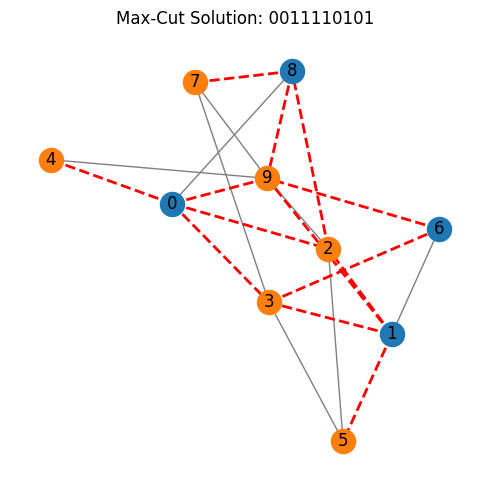

In [29]:
from qiskit.quantum_info import Statevector

n = G.number_of_nodes()
gammas, betas = np.split(opt_result.x, 2)

bqc = qc.assign_parameters(dict(zip(circuit_parameters, opt_result.x)))

counts = backend.run(bqc, shots = shots).result().get_counts()

print(counts)

most_common = max(counts, key=counts.get)
plot_graph(G, most_common)


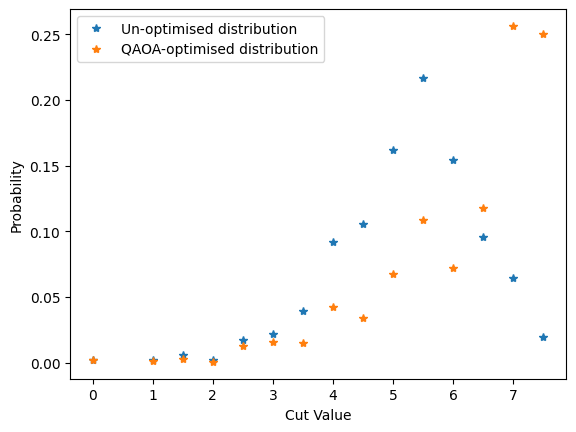

In [30]:
bqc.remove_final_measurements()


final_probability= Statevector.from_instruction(bqc).probabilities()

starting_probability = np.array(2**n * [1/2**n])
cut_values = np.array([cut_value(int2bits(i, n)[::-1], G) for i in range(2**n)])

unique_cuts, inverse = np.unique(cut_values, return_inverse=True)
agg_prob_final = np.zeros_like(unique_cuts, dtype=float)
agg_prob_start = np.zeros_like(unique_cuts, dtype=float)
np.add.at(agg_prob_final, inverse, final_probability)
np.add.at(agg_prob_start, inverse, starting_probability)


plt.plot(unique_cuts,  agg_prob_start, '*', label = 'Un-optimised distribution')
plt.plot(unique_cuts,  agg_prob_final, '*', label = 'QAOA-optimised distribution')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("Cut Value")
plt.show()